# Titiler-CMR Performance Benchmarking and Compatibility

This notebook helps you **validate compatibility** and **measure performance** of [TiTiler-CMR] tile rendering endpoints at different zoom levels for a given **Earthdata CMR concept ID**.

> **What is TiTiler-CMR?**  
> [TiTiler](https://github.com/developmentseed/titiler) is a lightweight dynamic tiling server for raster/COG data. **TiTiler-CMR** is a variant/deployment that integrates with NASA's **Common Metadata Repository (CMR)** so you can render tiles **directly from CMR-managed datasets** (e.g., HDF5/NetCDF4/GRIB hosted on Earthdata Cloud). It can resolve a **CMR concept ID** to a renderable item, and expose tile and statistics endpoints without you needing to manually construct source URLs.



In [1]:
import asyncio
import pandas as pd

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import morecantile
import earthaccess

from datacube_benchmark.titiler_cmr_utils import (
    DatasetParams,
    check_titiler_cmr_compatibility,
    benchmark_titiler_cmr,
    summarize_tiling_benchmark
)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
pd.set_option("display.max_colwidth", 120)

## Setup

- Choose a Titiler-CMR endpoint
- Pick a collection
- Define a temporal interval and (optionally) band list

In [2]:
endpoint = "https://staging.openveda.cloud/api/titiler-cmr"
concept_id = "C2021957295-LPCLOUD"  # Example: HLS Landsat 30m
concept_id = "C2565807733-LPCLOUD"

# Tile Matrix Set
projection = "WebMercatorQuad"
tms = morecantile.tms.get(projection)

# Dataset parameters
ds = DatasetParams(
    concept_id=concept_id,
    datetime_start=datetime(2024, 5, 1),
    datetime_end=datetime(2024, 5, 2),
    assets=["B04", "B03", "B02"],        # RGB bands
)


lng, lat = -91.0321, 46.7653

min_zoom, max_zoom = 3, 18      
tile_format = "png"
timeout_s = 30.0

We can further explore these granules using `earthaccess`: 

In [3]:
time_range = (ds.datetime_start.strftime("%Y-%m-%d"), ds.datetime_end.strftime("%Y-%m-%d"))

# Search for granules using the same temporal range
results = earthaccess.search_data(concept_id=concept_id, temporal=time_range)

print(f"Found {len(results)} granules between {time_range[0]} and {time_range[1]}")

for g in results:
    start = g["umm"]["TemporalExtent"]["RangeDateTime"]["BeginningDateTime"]
    size  = g["size"]

    print(f"\n{start} → {size:.2f} MB")

    # print all direct (S3) links for this granule
    for link in g.data_links(access="direct"):
        print(" ", link)


Found 2 granules between 2024-05-01 and 2024-05-02

2024-05-01T00:00:00.000Z → 52.98 MB
  s3://lp-prod-protected/MCD19A2CMG.061/MCD19A2CMG.A2024122.061.2024125083456/MCD19A2CMG.A2024122.061.2024125083456.hdf

2024-05-02T00:00:00.000Z → 52.58 MB
  s3://lp-prod-protected/MCD19A2CMG.061/MCD19A2CMG.A2024123.061.2024125085712/MCD19A2CMG.A2024123.061.2024125085712.hdf


In [4]:
#import json
#print(json.dumps(results[-1], indent=2))

## Compatibility Testing


Perform a lightweight compatibility test for a dataset (concept ID). It attempts a single **tile** at a representative (lon, lat, zoom) across several formats and resampling modes.

In [5]:
async def run_compat():
    report = await check_titiler_cmr_compatibility(
        endpoint=endpoint,
        ds=ds,
        lng=lng,
        lat=lat,
        zoom=8,
        tile_matrix_set_id="WebMercatorQuad",
        formats=["png", "jpeg", "webp", "tiff", "npy", "jp2", "pngraw", "jpg"],
        resampling_methods=("nearest", "bilinear"),
    )
    return report

compat = await run_compat()
print("\n== Compatibility Report ==")
print(f"concept_id : {compat.concept_id}")
print(f"compatible : {compat.ok}")
print(f"formats    : {compat.tested_formats}")
print(f"resampling : {compat.tested_resampling}")


== Compatibility Report ==
concept_id : C2565807733-LPCLOUD
compatible : True
formats    : {'png': True, 'jpeg': True, 'webp': True, 'tiff': True, 'npy': True, 'jp2': True, 'pngraw': True, 'jpg': True}
resampling : {'nearest': True, 'bilinear': True}


## Tiling Benchmark

In this part, we are going to measure response latency across the tiles at different zoom levels using `benchmark_titiler_cmr` function. 
This function simulates the load of a typical viewport render in a slippy map, where multiple adjacent tiles must be fetched in parallel to draw a single view.

Under the hood, `benchmark_titiler_cmr` computes the center tile for each zoom level, selects its neighboring tiles to approximate a viewport, and requests them concurrently from the TiTiler-CMR endpoint. This function returns a pandas DataFrame containing the response times for each tile request.

In [6]:
ds = DatasetParams(
    concept_id="C2565807733-LPCLOUD",
    datetime_start=datetime(2024, 5, 1),
    datetime_end=datetime(2024, 5, 2),
    assets=[ "B02","B03","B09"],        # RGB bands
)
async def run_tile_benchmark():
    df = await benchmark_titiler_cmr(
        endpoint=endpoint,
        ds=ds,
        tms=tms,
        min_zoom=min_zoom,
        max_zoom=max_zoom,
        lng=lng,
        lat=lat,
        format=tile_format,
        timeout_s=timeout_s,
    )
    return df

df_tiles =  await run_tile_benchmark()
df_tiles


,zoom,x,y,status_code,response_time_sec,response_size_bytes,is_error,has_data
0,3,0,0,200,0.169561,704,False,True
1,3,0,0,200,0.180774,704,False,True
2,3,1,0,200,0.177623,704,False,True
3,3,2,0,200,0.153130,704,False,True
4,3,3,0,200,0.169756,704,False,True
...,...,...,...,...,...,...,...,...
395,18,64782,92454,200,0.114911,704,False,True
396,18,64783,92454,200,0.087782,704,False,True
397,18,64784,92454,200,0.119139,704,False,True
398,18,64785,92454,200,0.086551,704,False,True


**Columns**
- `zoom, x, y` — XYZ tile indices
- `status_code` — HTTP code (200 = success, 204 = no-data, 4xx/5xx = errors)
- `response_time_sec` — wall time in seconds
- `response_size_bytes` — payload size
- `is_error, has_data` — convenience flags

Below are some quick summaries.


Now, let's create a simple function to summarize and plot latency vs. zoom level plot: 

In [8]:
async def summarize_and_plot_tiles(
    ds,
    *,
    endpoint: str,
    tms,
    min_zoom: int,
    max_zoom: int,
    lng: float,
    lat: float,
    tile_format: str,
    timeout_s: float = 30.0,
    jitter: float = 0.08,
    alpha: float = 0.35,
):
    async def run_tile_benchmark():
        df = await benchmark_titiler_cmr(
            endpoint=endpoint,
            ds=ds,
            tms=tms,
            min_zoom=min_zoom,
            max_zoom=max_zoom,
            lng=lng,
            lat=lat,
            format=tile_format,
            timeout_s=timeout_s,
        )
        return df

    df = await run_tile_benchmark()
    if df.empty:
        raise ValueError("Empty DataFrame: no results to summarize/plot.")

    summary = summarize_tiling_benchmark(df).copy()

    # Plot
    fig, ax = plt.subplots(figsize=(9, 5))
    # Leave room for outside legend on the right and multi-line title on top
    fig.subplots_adjust(right=0.72, top=0.78)

    # exact integer zoom ticks
    zoom_levels = sorted(int(z) for z in df["zoom"].unique())
    ax.set_xticks(zoom_levels)
    ax.set_xlim(min(zoom_levels) - 0.6, max(zoom_levels) + 0.6)

    # scatter + medians
    for z in zoom_levels:
        sub = df[df["zoom"] == z]
        x = np.random.normal(loc=z, scale=jitter, size=len(sub))  # jitter for visibility

        ok_mask = sub["status_code"] == 200
        err_mask = sub["is_error"]

        ax.scatter(
            x[ok_mask],
            sub.loc[ok_mask, "response_time_sec"],
            alpha=alpha,
            edgecolor="none",
        )
        ax.scatter(
            x[err_mask],
            sub.loc[err_mask, "response_time_sec"],
            marker="x",
            alpha=min(0.8, alpha + 0.25),
        )
        med = sub["response_time_sec"].median()
        ax.hlines(med, z - 0.45, z + 0.45, linestyles="--")

    ax.set_xlabel("Zoom level")
    ax.set_ylabel("Tile response time (s)")

    # single combined legend OUTSIDE (right)
    success_proxy = Line2D([], [], linestyle="none", marker="o", label="200 OK")
    error_proxy   = Line2D([], [], linestyle="none", marker="x", label="error/5xx")
    ax.legend(
        [success_proxy, error_proxy],
        ["200 OK", "error/5xx"],
        frameon=False,
        loc="upper left",
        bbox_to_anchor=(1.02, 1.00),  # outside
        borderaxespad=0.0,
    )

    # dataset info as multi-line TITLE
    info_lines = [
        f"concept_id: {ds.concept_id}",
        f"datetime: {ds.datetime_start.date()} → {ds.datetime_end.date()}",
        f"assets: {', '.join(ds.assets) if ds.assets else '—'}",
        f"resampling: {ds.resampling}",
        f"format: {tile_format}",
        f"endpoint: {endpoint}",
    ]
    ax.set_title("\n".join(info_lines), fontsize=9, loc="left", pad=12)

    ax.grid(True, axis="y", alpha=0.2)
    plt.tight_layout()
    return summary, (fig, ax)

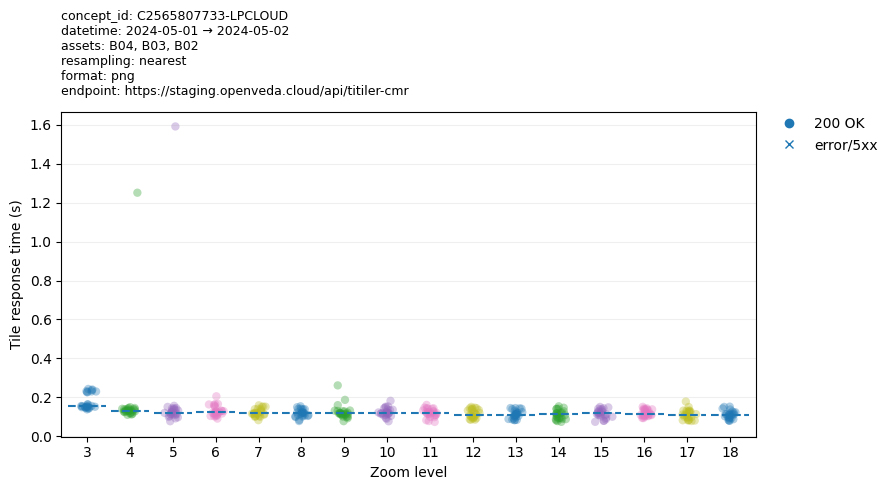

    zoom_level  total_requests  success_rate_pct  no_data_rate_pct  error_rate_pct  latency_median_s  latency_p95_s  \
0            3              25             100.0               0.0             0.0              0.15           0.24   
1            4              25             100.0               0.0             0.0              0.13           0.15   
2            5              25             100.0               0.0             0.0              0.12           0.16   
3            6              25             100.0               0.0             0.0              0.12           0.17   
4            7              25             100.0               0.0             0.0              0.12           0.15   
5            8              25             100.0               0.0             0.0              0.12           0.15   
6            9              25             100.0               0.0             0.0              0.12           0.18   
7           10              25             100.0

In [9]:
ds = DatasetParams(
    concept_id=concept_id,
    datetime_start=datetime(2024, 5, 1),
    datetime_end=datetime(2024, 5, 2),
    assets=["B04", "B03", "B02"],        # RGB bands
)

summary, (fig, ax) = await summarize_and_plot_tiles(
    ds,
    endpoint=endpoint,
    tms=tms,
    min_zoom=min_zoom,
    max_zoom=max_zoom,
    lng=lng,
    lat=lat,
    tile_format=tile_format,
    timeout_s=timeout_s,
)
plt.show()
print (summary)

Now, let's try to create similar plots for longer datetime range: 

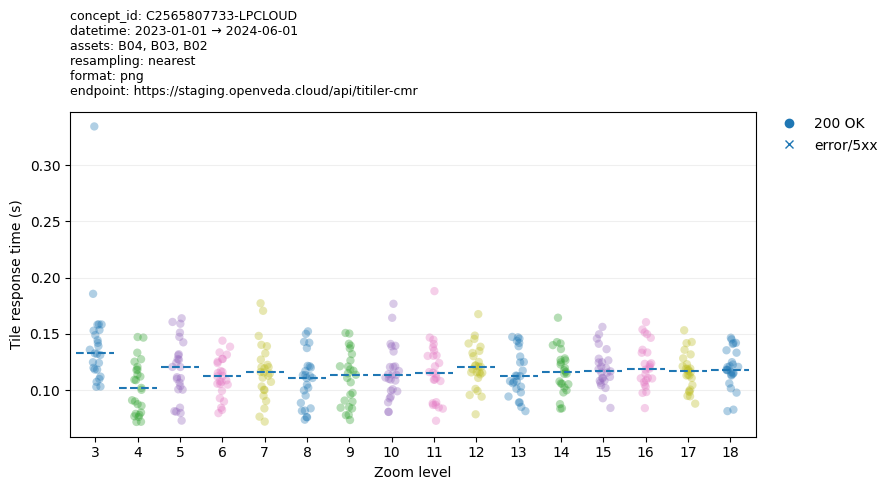

In [10]:
ds = DatasetParams(
    concept_id=concept_id,
    datetime_start=datetime(2023, 1, 1),
    datetime_end=datetime(2024, 6, 1),
    assets=["B04", "B03", "B02"],
)

summary, (fig, ax) = await summarize_and_plot_tiles(
    ds,
    endpoint=endpoint,
    tms=tms,
    min_zoom=min_zoom,
    max_zoom=max_zoom,
    lng=lng,
    lat=lat,
    tile_format=tile_format,
    timeout_s=timeout_s,
)
plt.show()

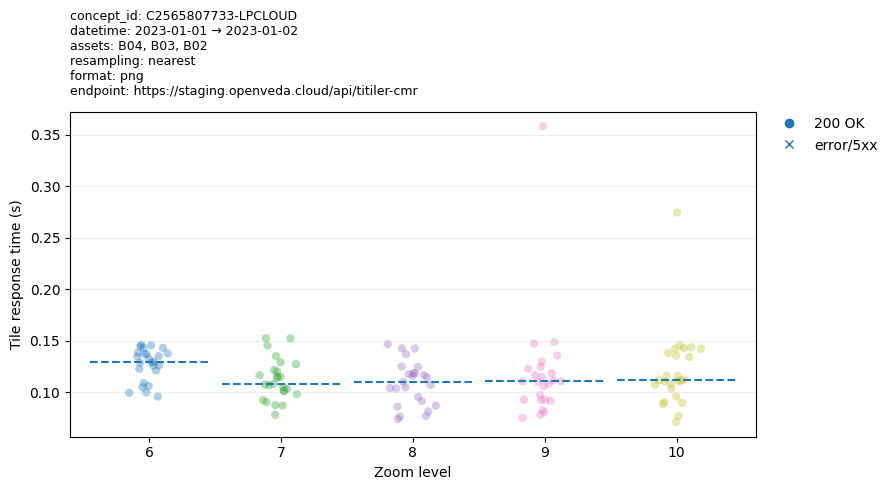

In [11]:
ds = DatasetParams(
    concept_id=concept_id,
    datetime_start=datetime(2023, 1, 1),
    datetime_end=datetime(2023, 1, 2),
    assets=["B04", "B03", "B02"],
)

min_zoom=6
max_zoom=10

summary, (fig, ax) = await summarize_and_plot_tiles(
    ds,
    endpoint=endpoint,
    tms=tms,
    min_zoom=min_zoom,
    max_zoom=max_zoom,
    lng=lng,
    lat=lat,
    tile_format=tile_format,
    timeout_s=timeout_s,
)
plt.show()

Now, let’s compare the median response times across zoom levels for different band configurations to understand how latency scales with resolution and number of bands.

In [18]:
min_zoom = 4
max_zoom = 15
zoom_levels = list(range(min_zoom, max_zoom + 1))

start = datetime(2023, 1, 1)
end   = datetime(2023, 1, 7)

asset_sets = {
    "1 band": ["B04"],
    "2 bands": ["B04", "B03"],
    "3 bands": ["B04", "B03", "B02"],

}

tasks = []
labels = []
for label, assets in asset_sets.items():
    ds = DatasetParams(
        concept_id=concept_id,
        datetime_start=start,
        datetime_end=end,
        assets=assets,
    )
    tasks.append(
        benchmark_titiler_cmr(
            endpoint=endpoint,
            ds=ds,
            tms=tms,
            min_zoom=min_zoom,
            max_zoom=max_zoom,
            lng=lng,
            lat=lat,
            format=tile_format,
            timeout_s=timeout_s,
        )
    )
    labels.append(label)

dfs = await asyncio.gather(*tasks)

median_by_zoom = []
for df in dfs:
    s = df.groupby("zoom")["response_time_sec"].median().reindex(zoom_levels)
    median_by_zoom.append(s)

panel_df = pd.concat(median_by_zoom, axis=1)
panel_df.columns = labels
panel_df


,1 band,2 bands,3 bands
zoom,,,
4,0.364033,0.373418,0.267472
5,0.194455,0.191249,0.170479
6,0.172494,0.172961,0.161257
7,0.178703,0.176825,0.157860
8,0.150544,0.150720,0.152232
9,0.134282,0.161683,0.155403
10,0.145112,0.149287,0.143364
11,0.147224,0.172446,0.151408
12,0.135160,0.138283,0.133471


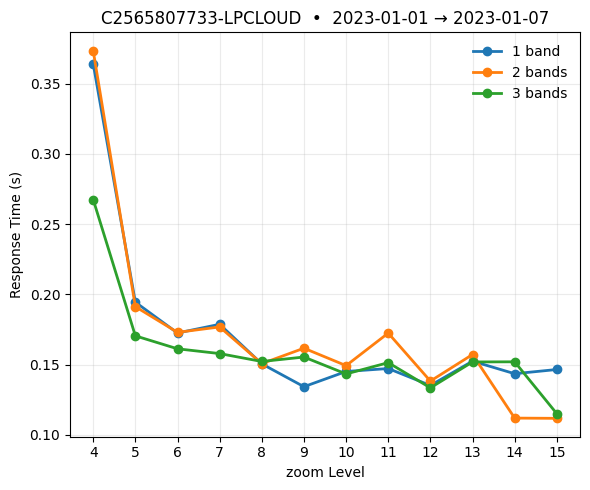

In [19]:
# --- plot all three lines together ---
fig, ax = plt.subplots(figsize=(6, 5))
for col in panel_df.columns:
    ax.plot(zoom_levels, panel_df[col].values, marker="o", linewidth=2, label=col)

ax.set_xticks(zoom_levels)             # exact zoom values
ax.set_xlabel("zoom Level")
ax.set_ylabel("Response Time (s)")
ax.grid(True, alpha=0.25)

# legend outside on the right
fig.subplots_adjust(right=0.78)
ax.legend(frameon=False, loc="best")

# optional title (set your collection name if you like)
ax.set_title(f"{concept_id}  •  {start.date()} → {end.date()}")

plt.tight_layout()
plt.show()


## Result Summaries & Plots

Interpretation tips:
- Prefer **single-day** (or narrow) intervals for responsive rendering
- Avoid very low zooms for heavy composites; consider **minzoom ≥ 7**